##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Here's the transfer learning workbook from this lesson. Let's step through it, and when we're done, you can try it for yourself. The first cell downloads the weights for a pre-trained inception network, and then instantiates a new instance of it using those weights. 

In [2]:

import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-04-24 01:09:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   101MB/s    in 0.8s    

2021-04-24 01:09:43 (101 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [ ]:
We will pull one of the convolutional layers as our input layer, and then take its output. We call this last output. Now, we'll set up our model taking the last output as the input to it. That'll be flattened, and then there'll be a dense layer, a dropout, and an output layer

We will pull one of the convolutional layers as our input layer, and then take its output. We call this last output. Now, we'll set up our model taking the last output as the input to it. That'll be flattened, and then there'll be a dense layer, a dropout, and an output layer

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


The next cell will download the abbreviated version of cats versus dogs, unzip it into training and validation directories, and then set up the image generators.

In [4]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-04-24 01:09:51--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  94.3MB/s    in 0.7s    

2021-04-24 01:09:52 (94.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The next cell will download the abbreviated version of cats versus dogs, unzip it into training and validation directories, and then set up the image generators.

In [5]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 55s - loss: 0.3455 - accuracy: 0.8620 - val_loss: 0.1538 - val_accuracy: 0.9340
Epoch 2/20
100/100 - 18s - loss: 0.1995 - accuracy: 0.9285 - val_loss: 0.1647 - val_accuracy: 0.9460
Epoch 3/20
100/100 - 18s - loss: 0.1872 - accuracy: 0.9315 - val_loss: 0.1627 - val_accuracy: 0.9520
Epoch 4/20
100/100 - 18s - loss: 0.1892 - accuracy: 0.9345 - val_loss: 0.1198 - val_accuracy: 0.9580
Epoch 5/20
100/100 - 18s - loss: 0.1774 - accuracy: 0.9350 - val_loss: 0.1530 - val_accuracy: 0.9500
Epoch 6/20
100/100 - 18s - loss: 0.1742 - accuracy: 0.9395 - val_loss: 0.1209 - val_accuracy: 0.9640
Epoch 7/20
100/100 - 19s - loss: 0.1981 - accuracy: 0.9360 - val_loss: 0.0934 - val_accuracy: 0.9710
Epoch 8/20
100/100 - 18s - loss: 0.1727 - accuracy: 0.9375 - val_loss: 0.1029 - val_accuracy: 0.9670
Epoch 9/20
100/100 - 18s - loss: 0.1483 - accuracy: 0.9510 - val_loss: 0.1310 - val_accuracy: 0.9660
Epoch 10/20
100/100 - 18s - loss: 0.1688 - accuracy: 0.9460 - val_loss: 0.1251 - val_accura

 So let's plot the 20 epochs and we can see that the curves are in sync. This is a good sign that we're avoiding overfitting. So that's it for this lesson. In this and in the last few lessons, we spent a lot of time looking at convolutional neural networks for classifying binary values. Of course another scenario happens when you have to classify multiple objects. So in the next lesson, we'll look at what you have to do to achieve that.

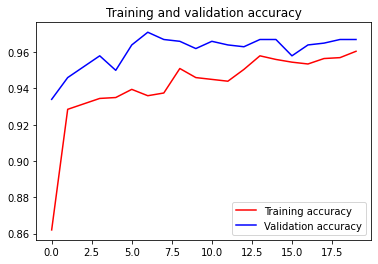

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()